## A2Summ: Multimodal Summarization with Dual Contrastive Losses  
#### Dhruv Khichi
#### 220150002

## Motivation

Multimodal summarization represents a frontier in AI research where different types of data—such as video, audio, and text—are processed in tandem to generate coherent summaries. I chose A2Summ because it introduces a novel transformer-based model that not only aligns temporal information across modalities but also leverages contrastive learning—both inter-sample and intra-sample—which has shown significant promise in recent research.


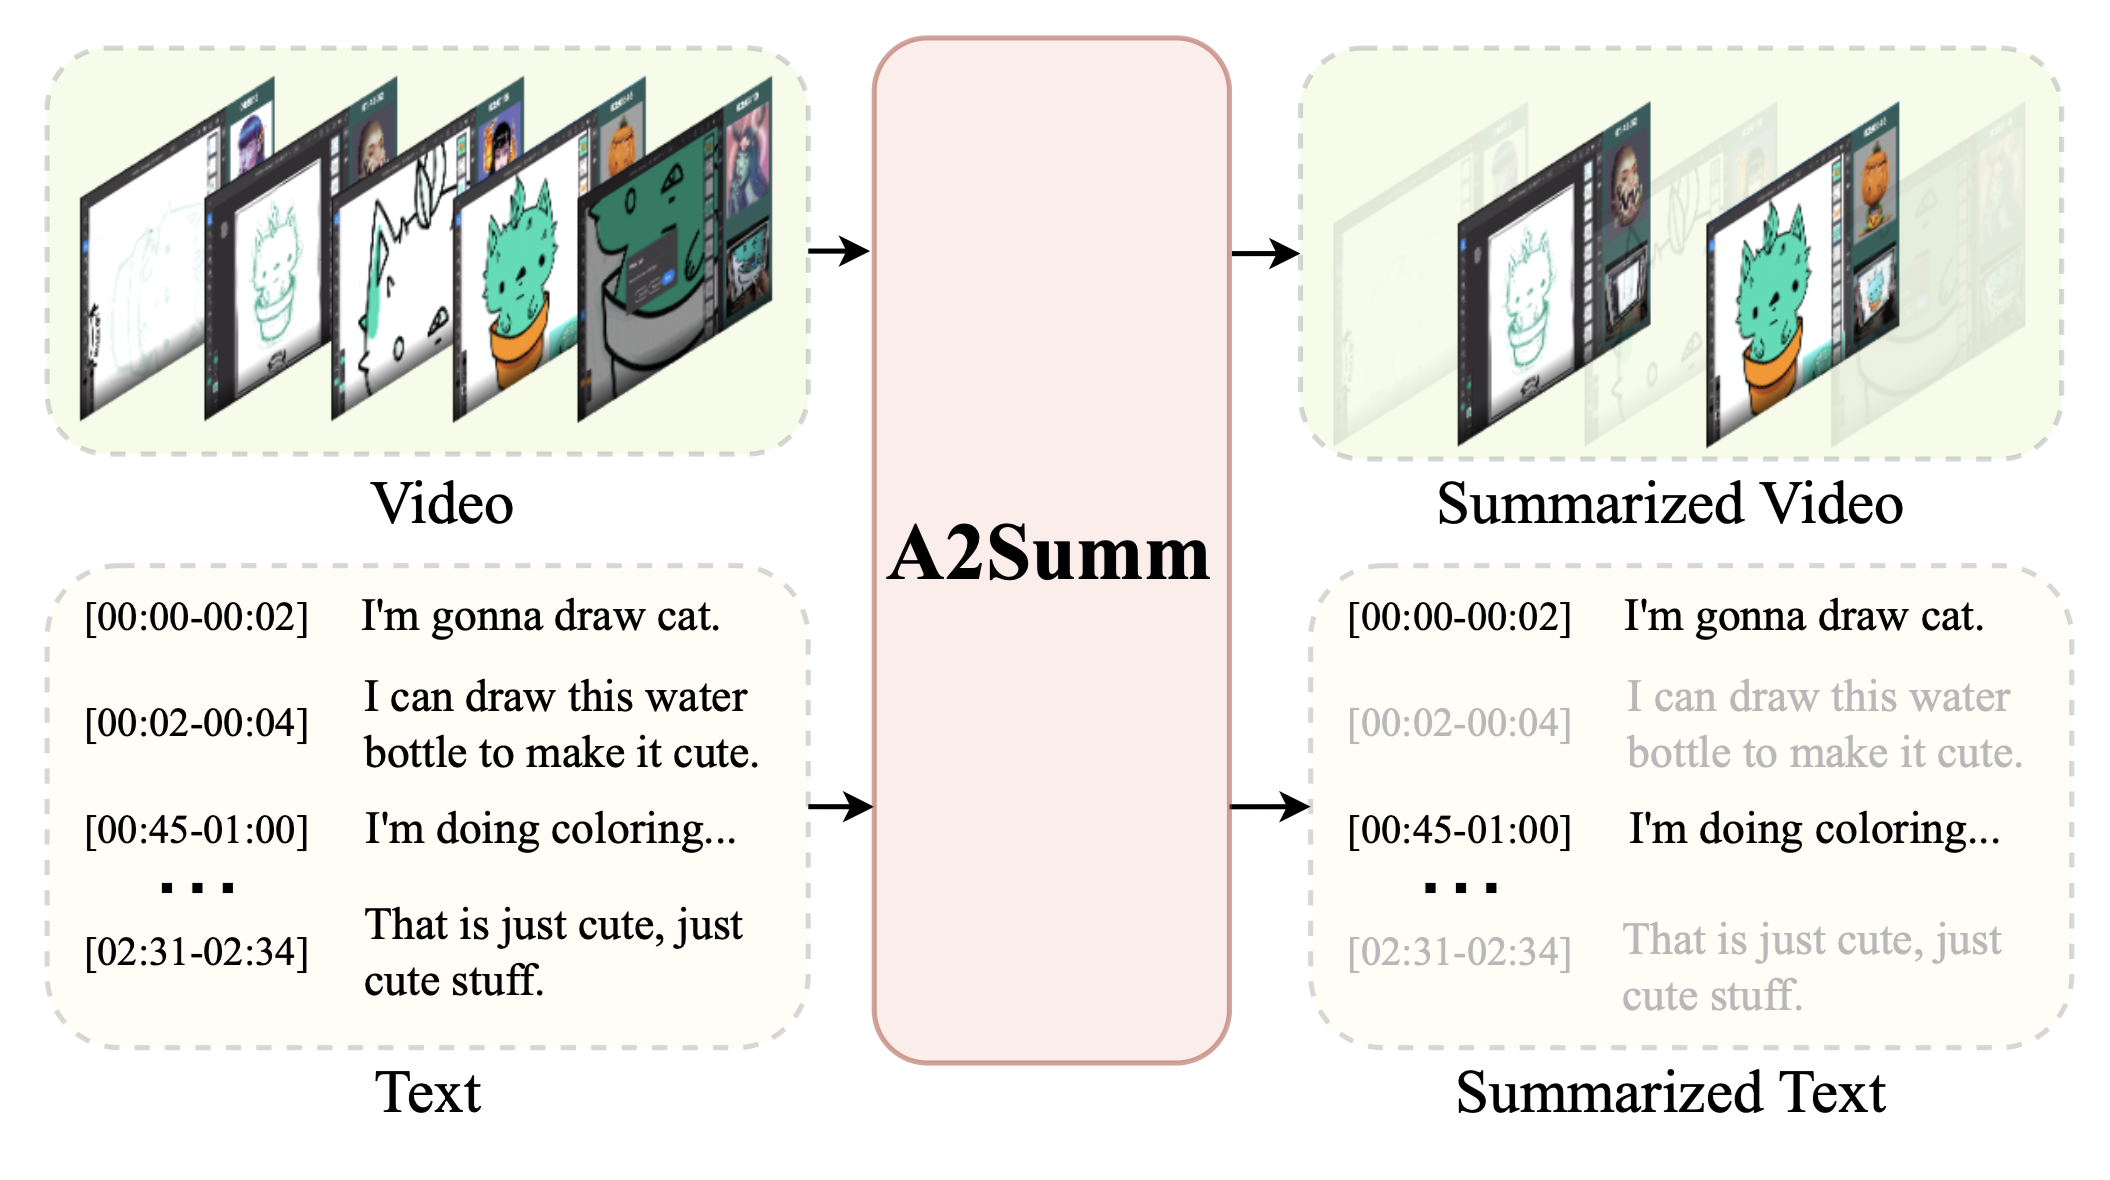

**Figure 1.** A2Summ is a unified multimodal summarization frame- work, which aligns and attends multimodality inputs while lever- aging time correspondence (e.g., video and transcript) and outputs the selected important frames and sentences as summaries.

## Connection to Past and Current Work

### A Brief History of Multimodal Learning and Summarization

- Early approaches focused on **unimodal summarization**, such as extractive text summarization (e.g., SummaRuNNer) or video-only methods (e.g., DR-DSN).
- **Multimodal Summarization** began to take shape with works like MSMO (2018), which integrated both image and text.
- Recently, models like **CLIP-It** used transformer architectures to align modalities but lacked **temporal alignment**.
- A2Summ advances this by:
  - Introducing **alignment-guided self-attention**.
  - Using **dual contrastive loss functions** to model cross-modal dependencies at multiple granularities.


## Learnings from the Paper

### Key Components of A2Summ:

- **Alignment-Guided Self-Attention**: Explicitly models correspondence between video and text using shared time segments.
- **Dual Contrastive Losses**:
  - **Inter-sample** loss ensures correct matching of video-text pairs across a batch.
  - **Intra-sample** loss aligns key frames with key sentences within each sample.
- **Mixture-of-Modality-Experts**: Separate feedforward layers for each modality.
- **BLiSS Dataset**: New large-scale dataset of livestream video and transcript pairs.


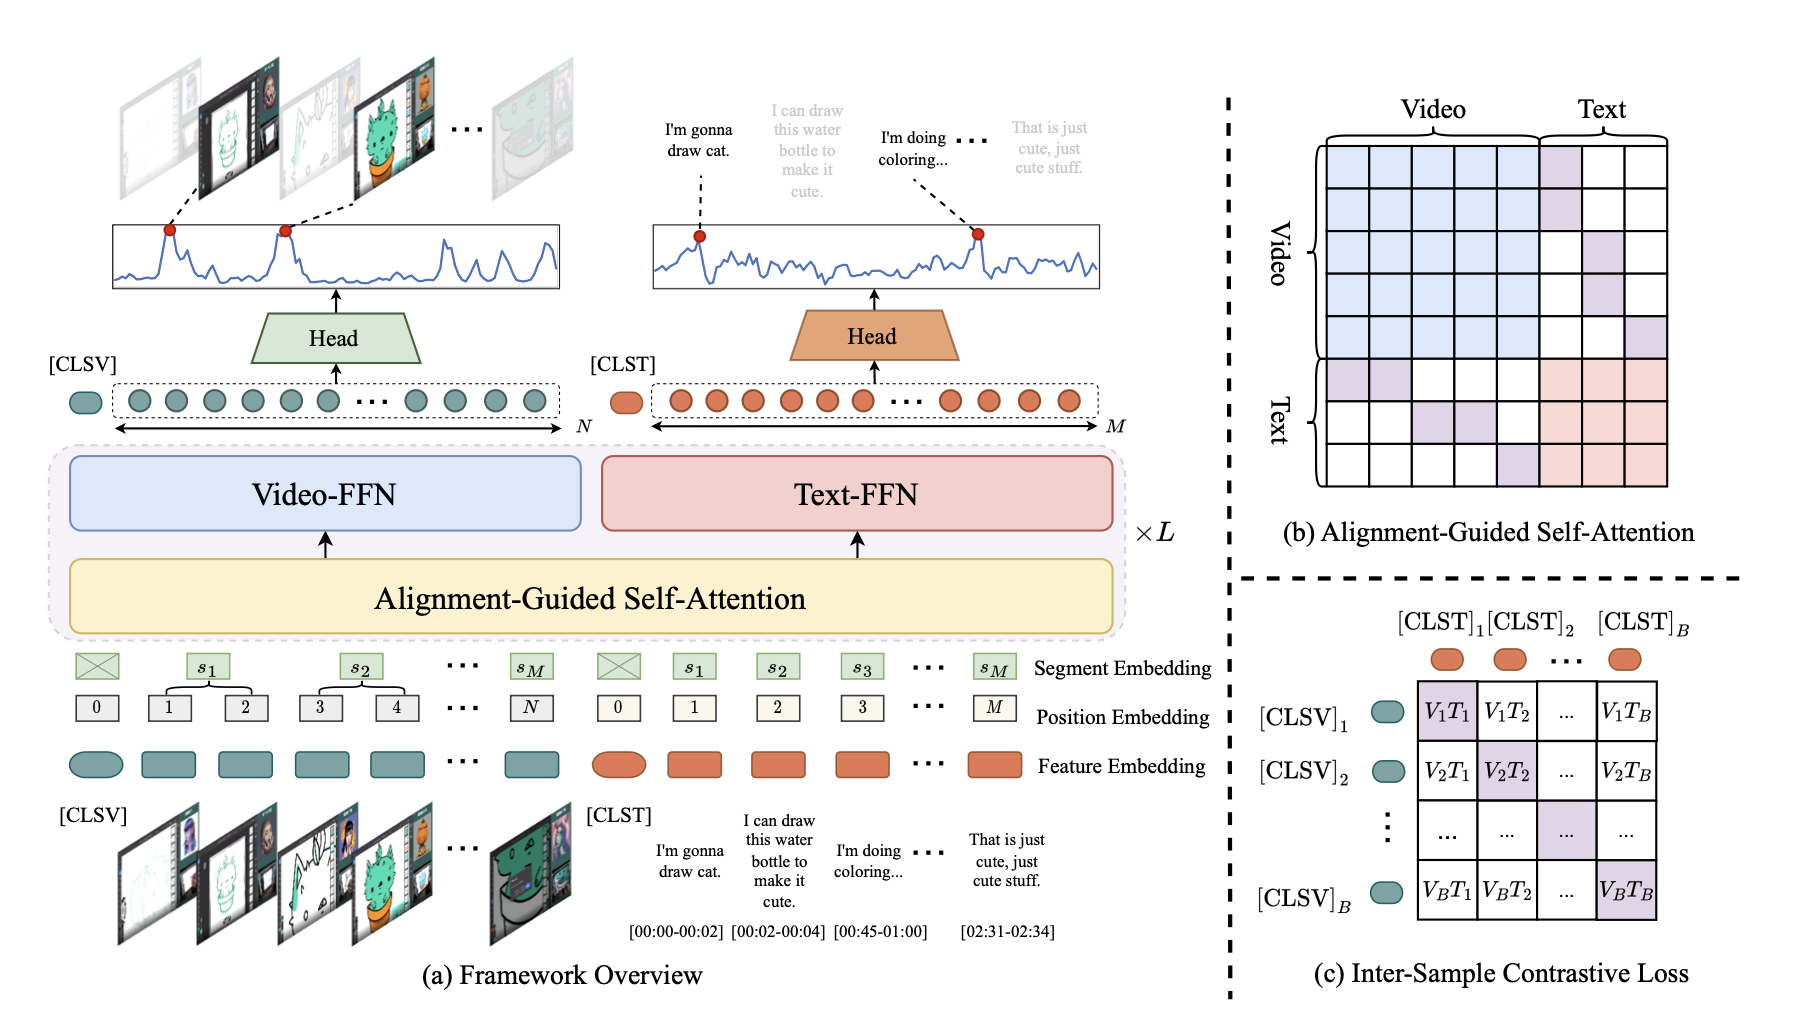

**Figure 2.** (a) The overview of A2Summ framework. Given N video frames and M text sequences as input, A2Summ predicts the important frames and sentences as multimodal summaries. (b) Alignment-guided self-attention module is applied to align and fuse each video and text pair. (c) Inter-sample contrastive loss is calculated by maximizing the similarity of [CLSV] and [CLST] tokens from the same pair while minimizing the similarity of tokens from different pairs. B is the batch size. Best viewed in color.

# Experiment

### A. BLiSS Dataset

The BLiSS dataset was curated from 628 livestream videos on Behance.net, each accompanied by transcripts and metadata. While audio data was available, it was excluded since the transcripts captured most spoken information. 

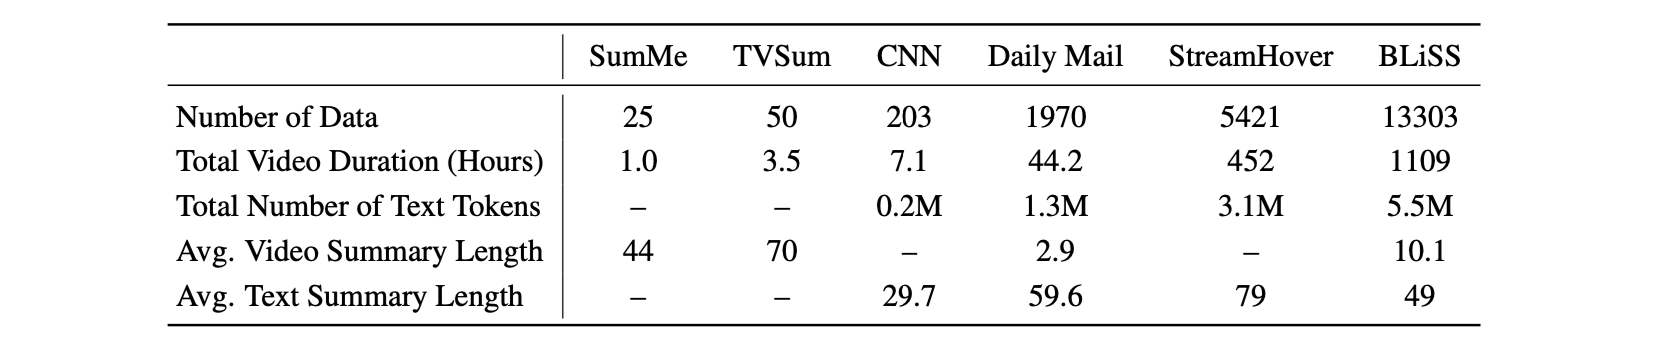

**Table 1.** Statistics comparison of BLiSS dataset with other datasets. 

**Annotation Process:**
- Videos were segmented into 5-minute clips.
- Annotators identified 5–10 **keywords** from transcript sentences.
- Sentences containing these keywords were tagged as **key sentences** (for extractive summarization).
- Annotators also provided **abstractive summaries** for each clip.
- Key frames were selected by comparing frames from video thumbnails to actual frames.

**Corpus Scale:**
- 13,303 video-text pairs
- Over 1,100 hours of video
- 5.5 million text tokens — significantly larger than Daily Mail, CNN, or StreamHover datasets

_Figure 3 below illustrates an example BLiSS clip with annotated frames, key sentences, and summaries._

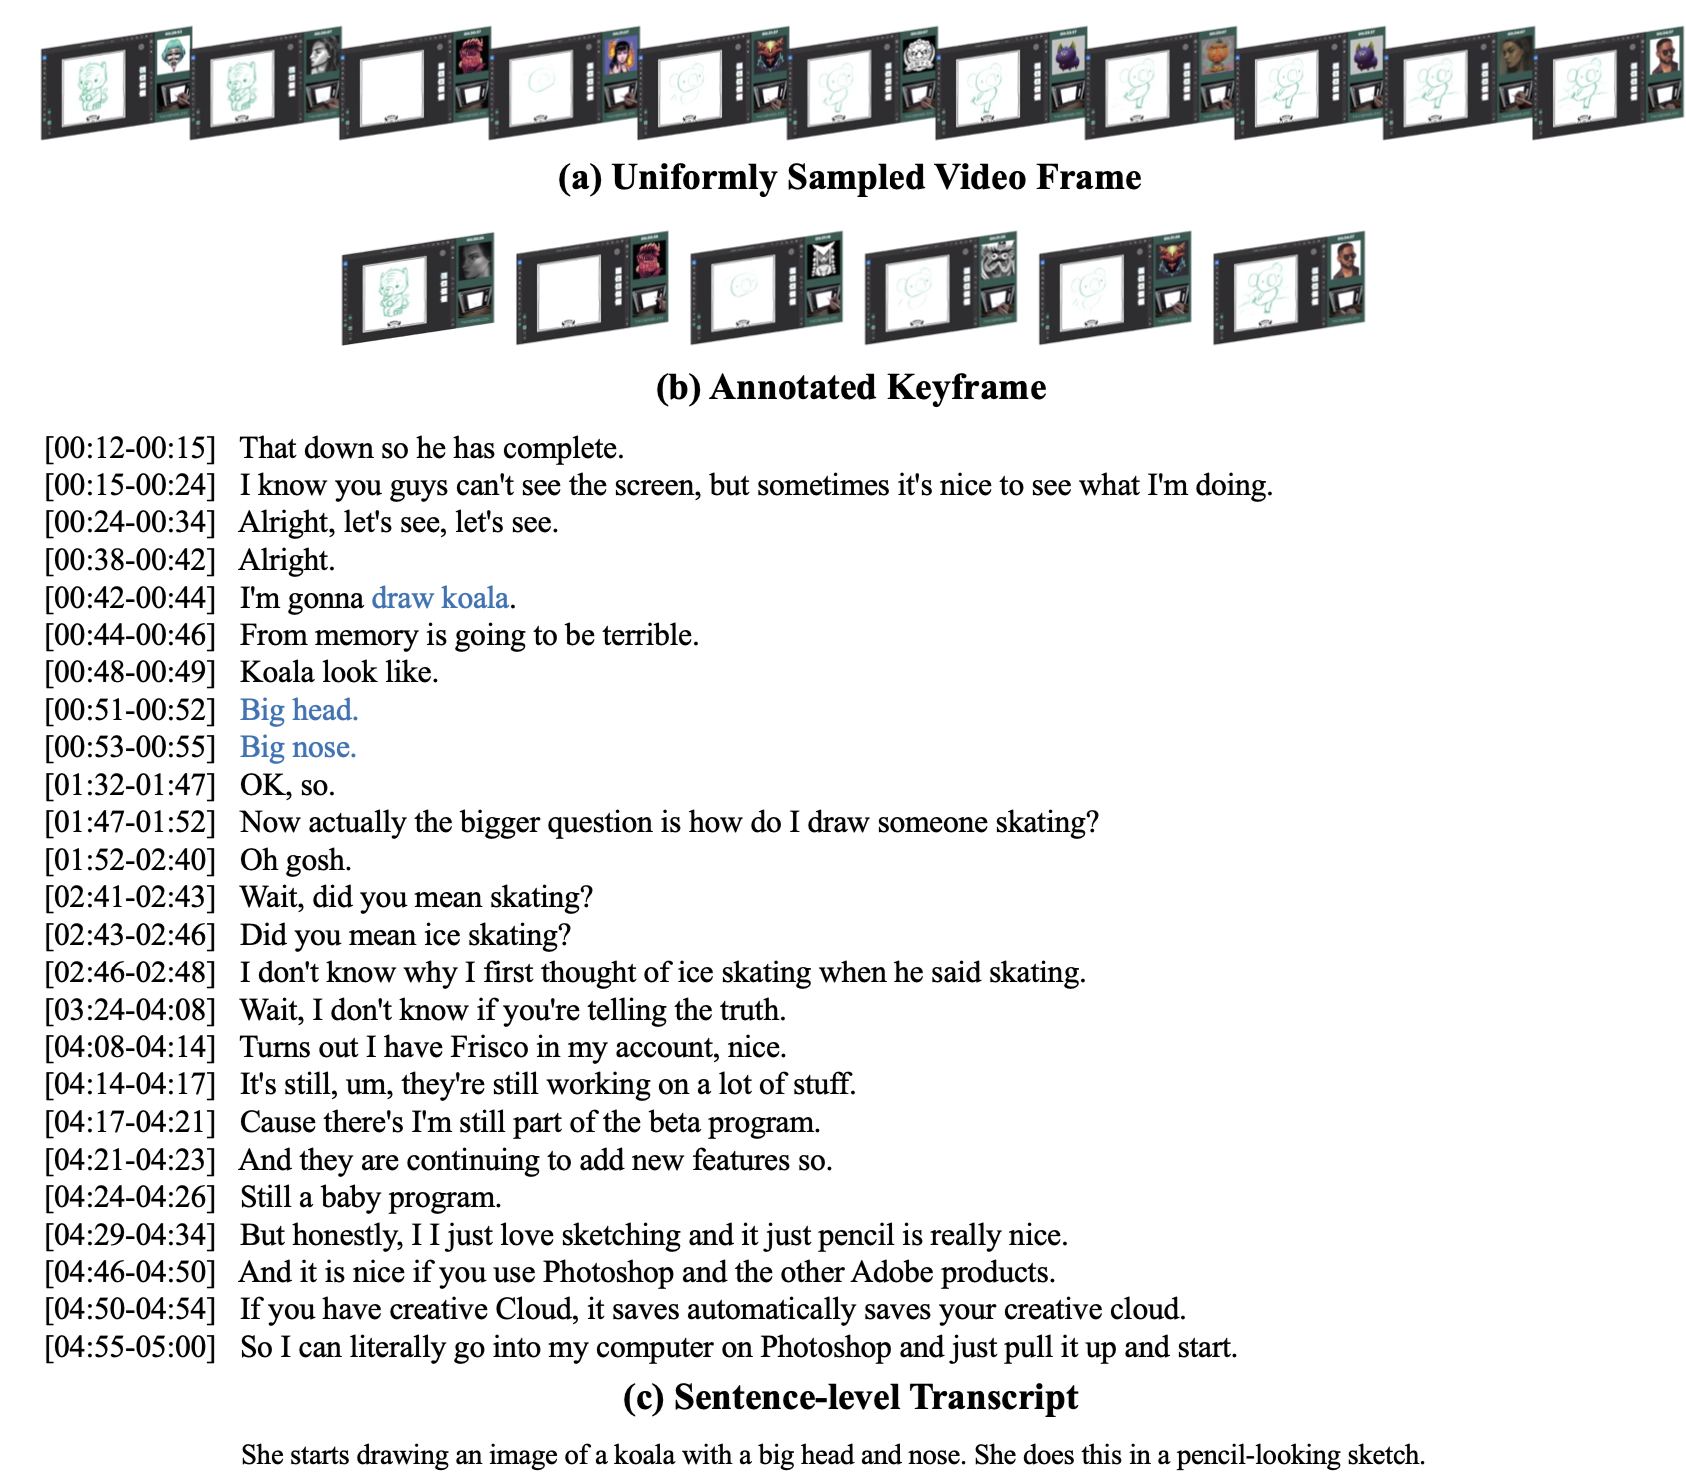

# (d) Annotated Abstractive Summary

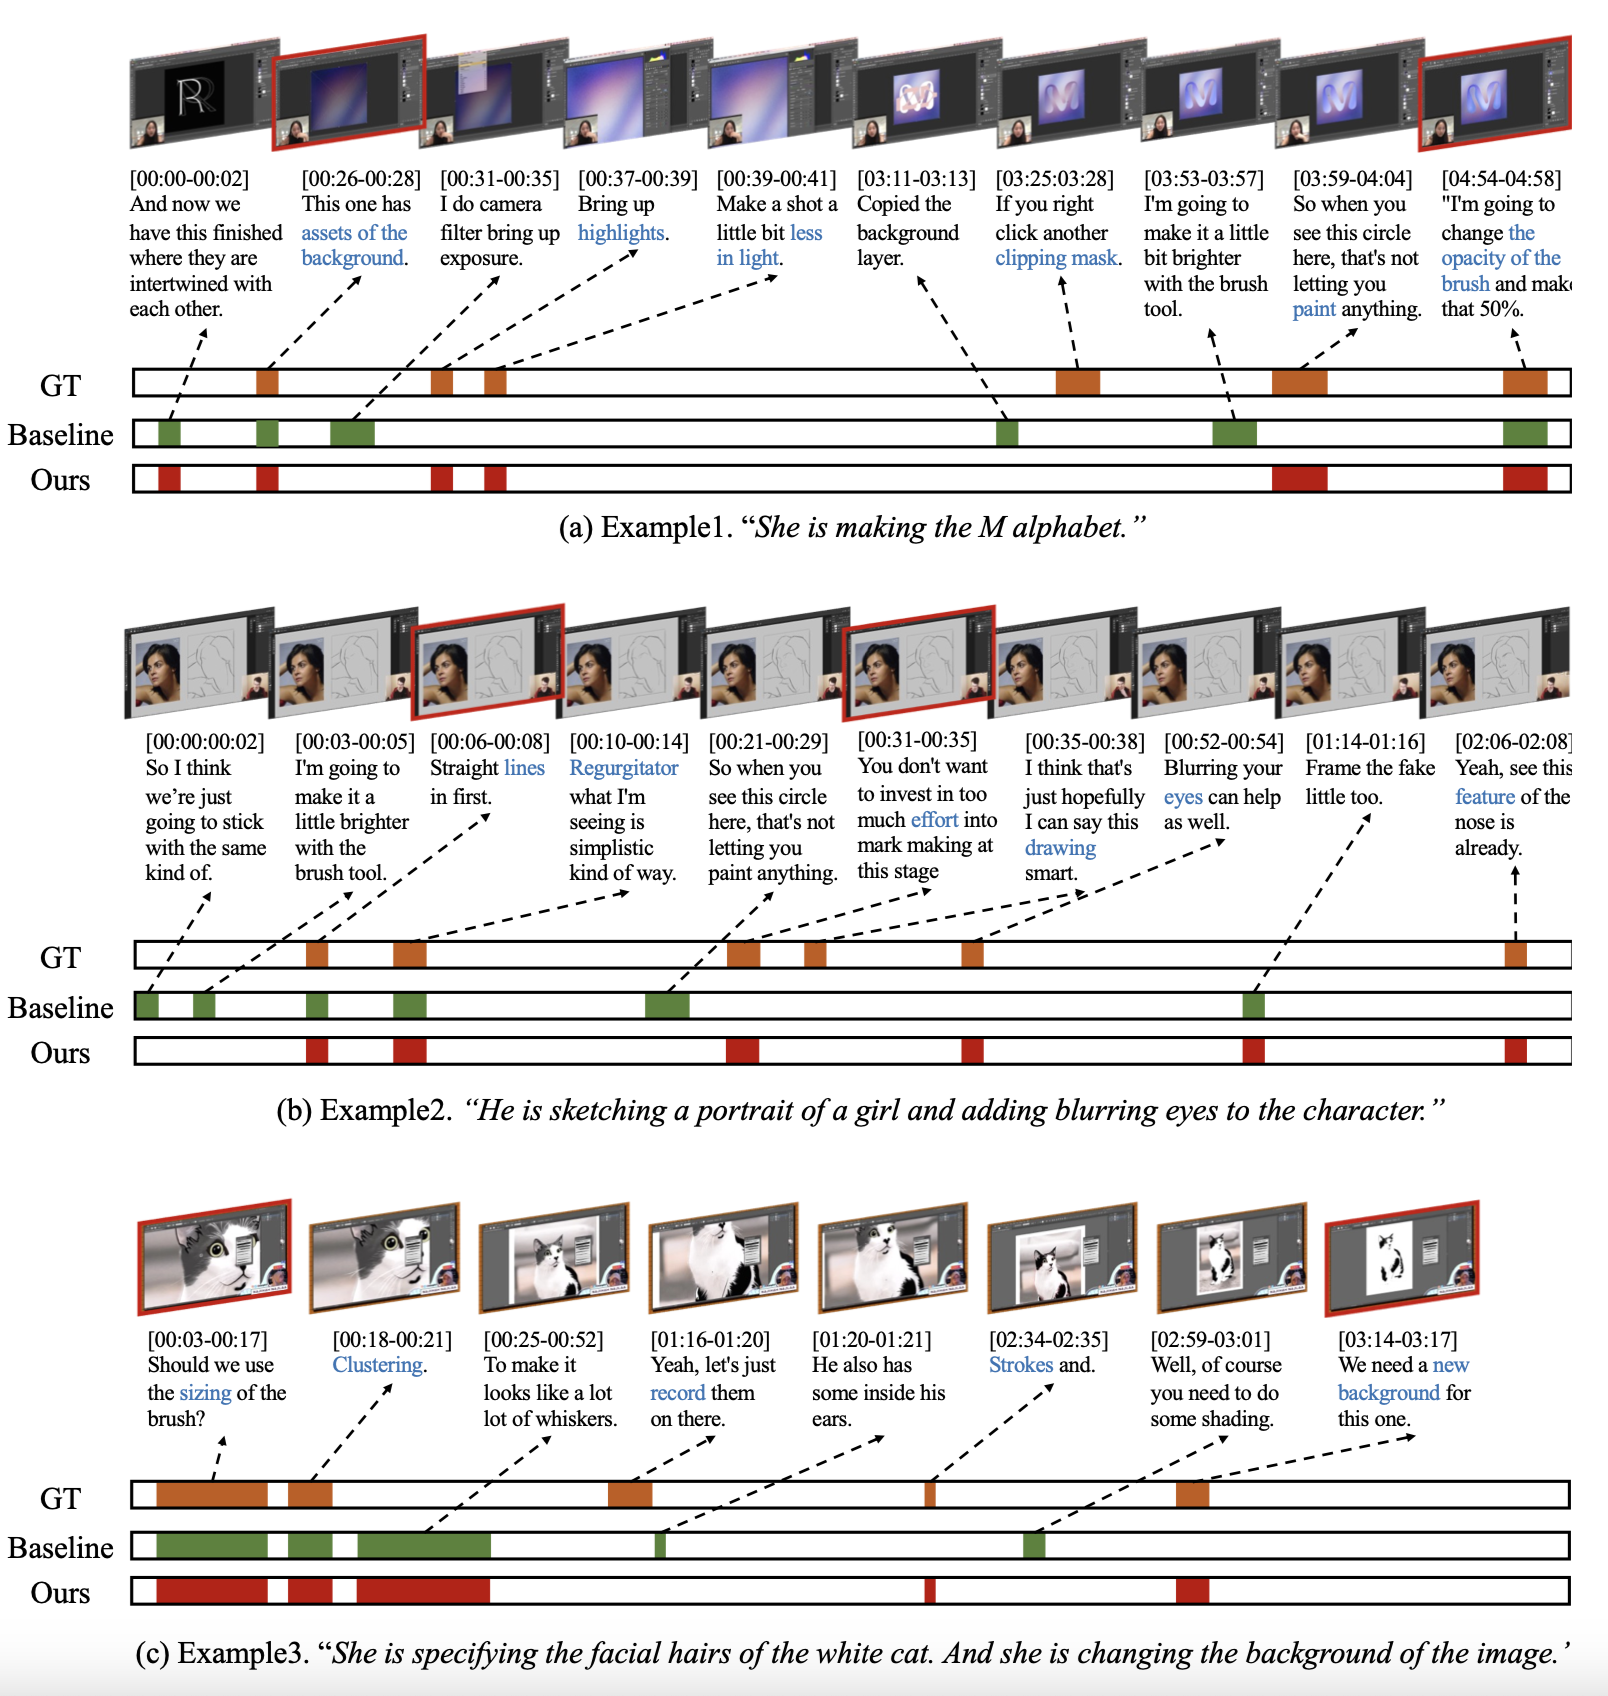

**Figure 3.** Visualization of multimodal summarization results for the BLiSS dataset. The ground-truth text summary, predictions from the baseline model and our A2Summ are shown for each video. “Baseline” denotes our A2Summ without the proposed alignment module and dual contrastive losses. The ground-truth keywords from key sentences are marked with blue color. We also show the corresponding video frames for each transcribed sentence where the frames with red boxes represent some of the predicted key-frames from our A2Summ. The title for each video clip is the annotated abstractive summary.

# Results on Bliss Dataset

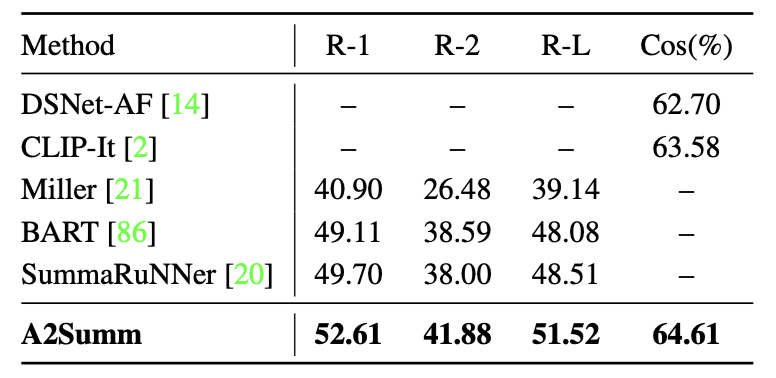

**Table 2.** Comparison results on the BLiSS dataset BART [86] is abstractive summarization based method, and the rest are extractive summarization based.

### B. Experiment Details

**Training Hyperparameters:**

- **Multimodal Summarization (Daily Mail, CNN):**
  - Batch Size: 4
  - Learning Rate: 2e-4
  - Weight Decay: 1e-7 (Daily Mail), 1e-5 (CNN)
  - Epochs: 100
  - Transformer Layers (L): 2
  - Hard-Negative Ratio (r): 8
  - Contrastive Weights: β = 0.001, λ = 0.001 (Daily Mail), λ = 0 (CNN)

- **Video Summarization (SumMe, TVSum):**
  - Batch Size: 4
  - Learning Rate: 1e-3
  - Weight Decay: 1e-3 (SumMe), 1e-5 (TVSum)
  - Epochs: 300
  - Transformer Layers (L): 2
  - Hard-Negative Ratio (r): 16
  - Contrastive Weights: β = 0.1, λ = 3 (SumMe), λ = 1 (TVSum)

- **BLiSS Dataset:**
  - Batch Size: 64
  - Learning Rate: 1e-3
  - Weight Decay: 1e-7
  - Epochs: 50
  - Transformer Layers (L): 6
  - Hard-Negative Ratio (r): 4
  - Contrastive Weights: β = 0.01, λ = 0.001

**Note:** A shared expansion window of 4 frames/sentences is used for hard-negative sampling across all datasets.

---

### C. More Qualitative Results

As visualized in Figure 3, A2Summ demonstrates:
- Higher **faithfulness in key sentence prediction** (text modality) compared to the baseline.
- Effective **key-frame selection** in video modality, even for long and visually redundant livestreams.
- This underlines the benefit of **alignment-guided self-attention** and **dual contrastive losses** in modeling cross-modal saliency.

## **Demo Code**

### 1. Alignment-Guided Self-Attention

A2Summ introduces an attention mask that aligns video frames and transcript sentences based on shared temporal segments. Instead of allowing full attention across all modalities, the model restricts attention to only relevant video-text pairs that fall within the same time window.

The matrix below shows where attention is allowed (value 1) and where it's masked out (value 0).


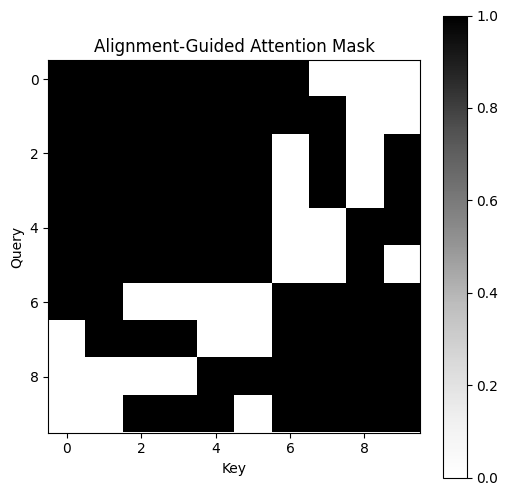

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose we have 6 video frames and 4 text sentences
N, M = 6, 4

# Sentence-to-frame alignment based on time segments
segment_mapping = {
    0: (0, 1),
    1: (1, 3),
    2: (4, 5),
    3: (2, 4),
}

# Initialize attention mask
attention_mask = np.zeros((N + M, N + M), dtype=int)

# Allow intra-modality attention
attention_mask[:N, :N] = 1  # video to video
attention_mask[N:, N:] = 1  # text to text

# Allow cross-modality attention only within aligned segments
for s_id, (start, end) in segment_mapping.items():
    for f_id in range(start, end + 1):
        attention_mask[N + s_id, f_id] = 1
        attention_mask[f_id, N + s_id] = 1

# Plot the attention mask
plt.figure(figsize=(6, 6))
plt.imshow(attention_mask, cmap='Greys')
plt.title("Alignment-Guided Attention Mask")
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()
plt.show()


### 2. Inter-Sample Contrastive Loss

This contrastive loss operates across a batch of video-text pairs. It aims to maximize the similarity between matching video-text embeddings while minimizing it for mismatched pairs in the batch. The loss function is symmetric for both video-to-text and text-to-video directions.


In [2]:
import torch
import torch.nn.functional as F

# Simulate a batch of 4 video-text pairs with 128-d embeddings
B, D = 4, 128
video_emb = F.normalize(torch.rand(B, D), dim=1)
text_emb = F.normalize(torch.rand(B, D), dim=1)

# Cosine similarity between all video-text pairs
sim_matrix = torch.matmul(video_emb, text_emb.T)  # shape [B, B]
labels = torch.arange(B)

# Compute cross-entropy loss
temperature = 0.07
loss_i2t = F.cross_entropy(sim_matrix / temperature, labels)
loss_t2i = F.cross_entropy(sim_matrix.T / temperature, labels)
inter_loss = (loss_i2t + loss_t2i) / 2

print(f"Inter-sample Contrastive Loss: {inter_loss.item():.4f}")


Inter-sample Contrastive Loss: 1.1496


### 3. Intra-Sample Contrastive Loss

This loss compares key frames and key sentences within a single video-text pair. It pulls together the positive frame-sentence pair and pushes apart hard negative pairs based on predicted importance scores.


In [3]:
# Positive frame and sentence (ground-truth aligned)
key_frame = F.normalize(torch.rand(1, D), dim=1)
key_sentence = F.normalize(torch.rand(1, D), dim=1)

# Hard negative frames (non-key)
neg_frames = F.normalize(torch.rand(3, D), dim=1)

# Cosine similarity with positive
pos_sim = F.cosine_similarity(key_frame, key_sentence)

# Cosine similarity with hard negatives
neg_sim = torch.matmul(key_sentence, neg_frames.T)

# Contrastive loss calculation
pos_score = torch.exp(pos_sim / temperature)
neg_score = torch.exp(neg_sim / temperature).sum()
intra_loss = -torch.log(pos_score / (pos_score + neg_score))

print(f"Intra-sample Contrastive Loss: {intra_loss.item():.4f}")


Intra-sample Contrastive Loss: 1.2274


### 4. Importance Scoring and Summary Selection

A2Summ assigns importance scores to each video frame and text sentence. The top-k frames and sentences are selected based on these scores to form the final multimodal summary.

## Reflections

### (a) What surprised you?

- The idea of using dual contrastive learning objectives to reinforce both inter- and intra-sample alignment is highly innovative.
- The way A2Summ avoids introducing noise from irrelevant content via segment-wise attention masks was a clever architectural choice.

### (b) What can be the scope for improvement?

- The model currently relies on pretrained features; end-to-end training could improve performance.
- It would be interesting to extend A2Summ to handle **more modalities** like audio or sensor data in real-world applications.


## References

- "Align and Attend: Multimodal Summarization with Dual Contrastive Losses." https://arxiv.org/abs/2303.07284
- CLIP: https://openai.com/research/clip
- SummaRuNNer, NN-SE, iPTNet papers for unimodal baselines.
- Tools used: Jupyter, NumPy, Matplotlib
